In [1]:
import pandas as pd
import numpy as np
import datetime, time, os, gc, re, sys
from functools import partial
import matplotlib.pyplot as plt
from utils import ignore_warnings, load_data

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
train = load_data('train', nrows=1000000)
def fprint(df, name):
    print(f'{name} shape: ({df.shape[0]:,}, {df.shape[1]})')
    
fprint(train, 'raw train')
train = (train[(train['action_type'] == 'clickout item') & 
               (train['impressions'].notna()) & 
               (train['reference'].notna())]
         .reset_index(drop=True))

fprint(train, 'train after filtering')

[05-05 11:22:11 - utils - load_data - INFO] Loading train using 1,000,000 rows which is 0.06% out of total train data


raw train shape: (1,000,000, 12)
train after filtering shape: (99,872, 12)


In [3]:
# %%time
# # also get test
# test = load_data('test')#, nrows=1000000)
# fprint(test, 'raw test')
# test = test[(test.action_type == 'clickout item') & (test.impressions.notna()) & (test.reference.notna())].reset_index(drop=True)
# fprint(test, 'test after')

In [4]:
# train = pd.concat([train, test], ignore_index=True)
# del test
# gc.collect()

In [5]:
# drop duplciates of rows with all same info except step
cols = [c for c in train.columns if c != 'step']
train = train.drop_duplicates(subset=cols, keep='last').reset_index(drop=True)
fprint(train, 'after dropping duplicates')

after dropping duplicates shape: (99,382, 12)


In [6]:
%%time
def session_duration(x):
    return x.max() - x.min()
# session_fts = train.groupby('session_id').agg({'session_id': 'size', 'timestamp': session_duration})
session_fts = train.groupby('session_id').size().reset_index(name='session_size')

CPU times: user 43.7 ms, sys: 0 ns, total: 43.7 ms
Wall time: 43.2 ms


In [7]:
# from clean_session import preprocess_sessions
# # train = preprocess_sessions(train,data_source='data')
# train = preprocess_sessions(None,data_source='data')

In [8]:
# %%time
# train_last = train.groupby('session_id').last().reset_index()

In [9]:
# train_last = train.copy()

In [10]:
# del train
# gc.collect()

In [13]:
train = pd.merge(train, session_fts, on='session_id')
fprint(train, 'train')

train shape: (99,382, 13)


In [14]:
# fprint(train_last, 'train_last')

---

In [15]:
# get only common cities
city_counts = train['city'].value_counts()
city_counts_cs = city_counts.cumsum()/(city_counts.sum())
city_counts_cs.head()

London, United Kingdom    0.019400
Paris, France             0.033316
Tokyo, Japan              0.046065
New York, USA             0.057365
Istanbul, Turkey          0.067467
Name: city, dtype: float64

In [16]:
# set the threshold we select cities
th = 0.9
above_th = city_counts_cs[city_counts_cs<th]
common_cities = above_th.index.values
train = train[train['city'].isin(common_cities)].reset_index(drop=True)
fprint(train, 'train')

train shape: (89,442, 13)


In [17]:
# create a label see if it contains any sortings
train['no_reorder'] = train['current_filters'].str.contains(r'\b(sort|focus)', case=False)
train['no_reorder'].fillna(False, inplace=True)
# train['current_filters'].dropna()[train['current_filters'].dropna().str.contains(r'\bsort', case=False)].value_counts()

/home/sam/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  


In [18]:
# current filters
train['cfs'] = train['current_filters'].str.lower().str.split('|')
train['ncfs'] = train['cfs'].str.len()

In [19]:
# add country infomation
train['country'] = train.city.str.split(',').str[1]

In [20]:
# we add prices split now after shrink (otherwise prices being list cannot get shrinked)
# prices
train['prices'] = train.prices.str.split('|')
train['prices'] = train.prices.apply(lambda x: [int(p) for p in x])
# pad it
train['prices'] = train.prices.apply(lambda x: np.pad(x, (0, 25-len(x)), mode='constant'))

In [21]:
# number of impressions
train['nimps'] = train.impressions.str.split('|').str.len()

In [22]:
%%time
# impressions
train['impressions'] = train['impressions'].str.split('|')
# convert impression id to int
train['impressions'] = train['impressions'].apply(lambda x: [int(i) for i in x])
train['reference'] = train['reference'].astype(int)
# pad to 25 len
train['impressions'] = train['impressions'].apply(lambda x: np.pad(x, (0, 25-len(x)), mode='constant'))

CPU times: user 1.59 s, sys: 72 ms, total: 1.66 s
Wall time: 1.64 s


In [23]:
n_item_ids = len(set(np.concatenate(train['impressions'].values)))
n_item_ids

257084

In [24]:
# filter out nan rows with reference_id not in impressions list, since if the true target in test
# is not in the impression list then it would not get evaluated
def assign_target(row):
    ref = row['reference']
    imp = list(row['impressions'])
    if ref in imp:
        return imp.index(ref)
    else:
        return np.nan
train['target'] = train.apply(assign_target, axis=1)
fprint(train, 'train')

train shape: (89,442, 19)


In [25]:
print(f'drop number of rows reference id not in impressions list: {train.target.isna().sum()}')
# drop the ones whose reference is not in the impression list
train = train[train['target'].notna()].reset_index(drop=True)
train['target'] = train['target'].astype(int)
fprint(train, 'train')

drop number of rows reference id not in impressions list: 50
train shape: (89,392, 19)


In [26]:
# look at the target distribution
pd.value_counts(train['target']).head()

0    27499
1     9486
2     6713
3     5319
4     4685
Name: target, dtype: int64

---

In [27]:
meta_df = load_data('item_metadata')

In [28]:
meta_df.head()

,item_id,properties
0,5101,Satellite TV|Golf Course|Airport Shuttle|Cosme...
1,5416,Satellite TV|Cosmetic Mirror|Safe (Hotel)|Tele...
2,5834,Satellite TV|Cosmetic Mirror|Safe (Hotel)|Tele...
3,5910,Satellite TV|Sailing|Cosmetic Mirror|Telephone...
4,6066,Satellite TV|Sailing|Diving|Cosmetic Mirror|Sa...


In [29]:
meta_df['properties'] = meta_df['properties'].str.lower().str.split('|')

In [30]:
all_properties = np.concatenate(meta_df['properties'].values)

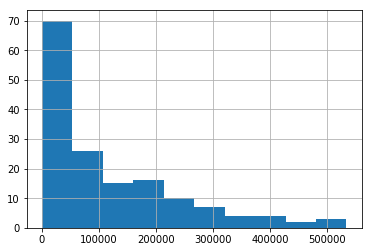

In [31]:
_ = pd.value_counts(all_properties).hist()

In [32]:
pd.value_counts(all_properties).tail()

hostal (es)     3282
camping site    2526
szep kartya     1533
kosher food     1248
water slide      349
dtype: int64

In [33]:
unique_properties = list(set(all_properties))
property2natural = {v: k for k, v in enumerate(unique_properties)}
del all_properties
gc.collect()

21

In [34]:
n_properties = len(unique_properties)
n_properties

157

In [35]:
meta_df['properties'] = meta_df['properties'].apply(lambda ps: [property2natural[p] for p in ps])

In [36]:
meta_df['properties'] = meta_df['properties'].apply(lambda ps: np.sum(np.eye(n_properties, dtype=int)[ps], axis=0))

In [37]:
meta_mapping = dict(meta_df[['item_id', 'properties']].values)

In [38]:
# add a mapping for the padded values
# meta_mapping[0] = np.zeros(n_properties, dtype=int)

In [39]:
del meta_df, unique_properties, property2natural
gc.collect()

0

---

In [40]:
%%time
train['impressions'] = (train['impressions']
                        .apply(lambda imps: np.vstack([meta_mapping[i] 
                                                      if i in meta_mapping.keys()
                                                      else np.zeros(n_properties, dtype=int) 
                                                      for i in imps])))
del meta_mapping
gc.collect()

CPU times: user 4.51 s, sys: 360 ms, total: 4.87 s
Wall time: 4.87 s


---

In [41]:
# current_filters
all_cfs = np.concatenate(train['cfs'].dropna().values)
pd.value_counts(all_cfs).head()

sort by price        6613
focus on distance    4473
hotel                3779
5 star               2995
4 star               2859
dtype: int64

In [42]:
pd.value_counts(all_cfs, normalize=True).cumsum().head()

sort by price        0.141822
focus on distance    0.237749
hotel                0.318793
5 star               0.383023
4 star               0.444337
dtype: float64

In [43]:
unique_cfs = list(set(all_cfs))
cfs_mapping = {v: k for k, v in enumerate(unique_cfs)}
n_cfs = len(unique_cfs)
n_cfs

99

In [44]:
train.loc[train['cfs'].notna(), 'cfs'] = (train.loc[train['cfs'].notna(), 'cfs']
                                          .apply(lambda cfs: [cfs_mapping[cf] for cf in cfs]))

In [45]:
%%time
train['cfs'] = (train['cfs'].apply(lambda cfs: np.sum(np.eye(n_cfs, dtype=int)[cfs], axis=0) 
                                   if type(cfs) ==list else np.zeros(n_cfs, dtype=int)))

CPU times: user 307 ms, sys: 0 ns, total: 307 ms
Wall time: 307 ms


In [46]:
del cfs_mapping
gc.collect()

0

---

---

In [47]:
# encode city, platform and device
def categorize(df, cols):
    for col in cols:
        print('converting', col)
        unique_values = df[col].unique()
        mapping = {v: k for k, v in enumerate(unique_values)}
        df[col] = df[col].map(mapping)
        
categorize(train, ['city', 'platform', 'device', 'country'])

converting city
converting platform
converting device
converting country


In [48]:
train['device'].unique()

array([0, 1, 2])

In [49]:
train = pd.get_dummies(train, columns=['device'], drop_first=True)

In [50]:
# # look at price distribution
# all_prices = np.concatenate(train.prices.values)
# _= plt.hist(all_prices, bins=20)

In [51]:
# np.max(all_prices), np.min(all_prices[all_prices!=0]), np.mean(all_prices), np.median(all_prices)

In [52]:
# _= plt.hist(np.log1p(all_prices), bins=20)

In [53]:
# m = np.mean(np.log1p(all_prices))
# sd = np.std(np.log1p(all_prices))
# _ = plt.hist((np.log1p(all_prices)-m)/sd)

In [54]:
# maybe normalize to percentage within each records, check does each item_id have the same price over all records
def normalize(ps):
    p_arr = np.array(ps)
    return p_arr/(p_arr.max())

train['prices'] = train['prices'].apply(normalize)
prices = np.array(list(train['prices'].values))
del train['prices']

In [55]:
# # IMPRESSIONS
# impressions = np.array(list(train['impressions'].values))
# # map each item_id to integer value
# # impressions = np.array([[imps_mapping[j] for j in i] for i in impressions])
# del train['impressions']
# CURRENT_FILTERS
cfilters = np.array(list(train['cfs'].values))
del train['cfs']
# record no_reorder info
no_reorders = train['no_reorder'].values
del train['no_reorder']
# CITY
cities = train['city'].values
n_city = train['city'].nunique()
del train['city']
# COUNTRY
countries = train['country'].values
n_country = train['country'].nunique()
del train['country']
# PLATFORM
platforms = train['platform'].values
n_plat = train['platform'].nunique()
del train['platform']
# DEVICES
devices = train[['device_1', 'device_2']].values
del train['device_1'], train['device_2']

# SIZES
sizes = train['session_size'].values
del train['session_size']

# SESSION_ID
sids = train['session_id'].values
del train['session_id']
# TARGETS
targets = train['target'].values
del train['target']


# IMPRESSIONS
impressions = np.array(list(train['impressions'].values))
del train['impressions']

In [57]:
def iterate_minibatches(no_reorders, sizes, impressions, prices, cfilters, cities, countries, platforms, devices, 
                        batchsize, targets, shuffle=True, reorder=True):
    # default we will shuffle
    indices = np.arange(len(targets))
    while True:
        if shuffle:
            np.random.shuffle(indices)
        for start_idx in range(0, len(targets), batchsize):
            excerpt = indices[start_idx:start_idx+batchsize]
            nos = no_reorders[excerpt]
#             print(f'allowed reorder:{nos.sum()}')
            ss = sizes[excerpt]
            imps = impressions[excerpt]
            ps = prices[excerpt]
            cfs = cfilters[excerpt]
            cis = cities[excerpt]
            cos = countries[excerpt]
            plats = platforms[excerpt]
            ds = devices[excerpt]
            ys = targets[excerpt]
#             print(pd.value_counts(ys))
            if reorder and np.sum(nos) != 0:
                re_ss = ss[nos]
                re_imps = imps[nos]
                re_ps = ps[nos]
                re_cfs = cfs[nos]
                re_cis = cis[nos]
                re_cos = cos[nos]
                re_plats = plats[nos]
                re_ds = ds[nos]
                re_ys = ys[nos]

                # randomly shuffle the order of the impressions and prices
                reorder_ind = ([np.random.choice(np.arange(25, dtype='int'), 25, replace=False) 
                                for _ in range(len(re_imps))])
#                 print([i[0] for i in reorder_ind])
                reorder_imp = re_imps[np.arange(re_imps.shape[0])[:, None], reorder_ind]
                reorder_price = re_ps[np.arange(re_ps.shape[0])[:, None], reorder_ind]
#                 reorder_ys = re_ys[np.arange(re_ys.shape[0]), reorder_ind]
                reorder_ys = [reorder_ind[i][re_ys[i]] for i in range(len(reorder_ind))]
#                 print(pd.value_counts(reorder_ys))
        
                # concatenate them back
                yield ([np.hstack((ss, re_ss)),
                        np.vstack((imps, reorder_imp)),
                        np.vstack((ps, reorder_price))[:, :, None],
                        np.vstack((cfs, re_cfs)),
                        np.hstack((cis, re_cis)), 
                        np.hstack((cos, re_cos)), 
                        np.hstack((plats, re_plats)),
                        np.vstack((ds, re_ds))],
#                        np.vstack((ys, reorder_ys)))
                       np.hstack((ys, reorder_ys)))
            else:
                yield ([ss, imps, ps[:, :, None], cfs, cis, cos, plats, ds], ys)

In [58]:
# from sklearn.metrics import roc_auc_score
# from keras.callbacks import Callback

# class Mrr(Callback):
#     def __init__(self, validation_data=validation_data, interval=2):
#         super(Callback, self).__init__()
#         self.interval = interval
#         self.X_val, self.y_val = validation_data
#         self.y_val = y_val

#     def on_epoch_end(self, epoch, logs={}):
#         if epoch % self.interval == 0:
#             y_pred = self.model.predict_generator(self.val_gen, verbose=0)
#             val_mrr = np.mean(1/(np.where(np.argsort(y_pred)[:, ::-1] == y_val[val_pred.shape[0]].reshape(-1, 1))[1]+1))
#             print("interval evaluation - epoch: {:d} - score: {:.6f}".format(epoch, val_mrr))

In [59]:
# a = np.random.randint(0, 10, 10)
# a

In [60]:
# b = [np.random.choice(np.arange(25, dtype='int'), 25, replace=False) 
#                                 for _ in range(len(a))]
# b

In [61]:
# [b[i][a[i]] for i in range(len(a))]

In [62]:
def nemd(n):
    return int(n**(1/4))

In [63]:
nemd(n_city), nemd(n_country), nemd(n_plat)

(7, 3, 2)

In [64]:
# create data generator [imps, ps, cis, cos, plats, ds], ys
# train_gen = iterate_minibatches(trn_no, trn_imp, trn_price, trn_cfilter, trn_city, trn_country, 
#                                 trn_plat, trn_dev, batch_size, train_y_binary, shuffle=True, reorder=True)

# create data generator [imps, ps, cis, cos, plats, ds], ys
# train_gen = iterate_minibatches(trn_no, trn_imp, trn_price, trn_cfilter, trn_city, trn_country, 
#                                 trn_plat, trn_dev, batch_size, y_trn, shuffle=True, reorder=True)

# val_gen = iterate_minibatches(val_no, val_imp, val_price, val_cfilter, val_city, val_country, 
#                               val_plat, val_dev, batch_size, val_y_binary, shuffle=False, reorder=False)

In [65]:
# for i in train_gen:
# #     for j in i[0]:
# #         print(j.shape)
#     print(pd.value_counts(i[1]))
# #     _ =i[1]
#     break

In [66]:
# for i in val_gen:
#     for j in i[0]:
#         print(j.shape)
#     print('===', i[1].shape)
#     break

In [67]:
# for c in [trn_imp, trn_price, trn_cfilter, trn_city, trn_country, trn_plat, trn_dev]:
#     print(c.shape)

In [68]:
n_uniques = {'city': n_city, 'country': n_country, 'cfilter': n_cfs, 'platform': n_plat}
n_uniques

{'city': 3413, 'country': 134, 'cfilter': 99, 'platform': 55}

In [69]:
for k,v in n_uniques.items():
    print(f'{k}, {v**0.25:.2f}')

city, 7.64
country, 3.40
cfilter, 3.15
platform, 2.72


In [71]:
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from sklearn.model_selection import StratifiedKFold
from datetime import datetime as dt
from nn_model import build_model
from keras.utils import plot_model

batch_size = 128
# n_repeat = 2
n_epochs = 500

skf = StratifiedKFold(n_splits=6)

for trn_ind, val_ind in skf.split(targets, targets):
    trn_ss, val_ss = sizes[trn_ind], sizes[val_ind]
    trn_no, val_no = no_reorders[trn_ind], no_reorders[val_ind]
    trn_imp, val_imp = impressions[trn_ind], impressions[val_ind]
    trn_price, val_price = prices[trn_ind], prices[val_ind]
    trn_cfilter, val_cfilter = cfilters[trn_ind], cfilters[val_ind]
    trn_city, val_city = cities[trn_ind], cities[val_ind]
    trn_country, val_country = countries[trn_ind], countries[val_ind]
    trn_plat, val_plat = platforms[trn_ind], platforms[val_ind]
    trn_dev, val_dev = devices[trn_ind], devices[val_ind]
    
    y_trn, y_val = targets[trn_ind], targets[val_ind]
    
    # create data generator [imps, ps, cis, cos, plats, ds], ys
    train_gen = iterate_minibatches(trn_ss, trn_no, trn_imp, trn_price, trn_cfilter, trn_city, trn_country, 
                                    trn_plat, trn_dev, batch_size, y_trn, shuffle=True, reorder=True)
    
    val_gen = iterate_minibatches(val_ss, val_no, val_imp, val_price, val_cfilter, val_city, val_country, 
                                  val_plat, val_dev, batch_size, y_val, shuffle=False, reorder=False)
#     TEMP
#     del impressions, prices, cities, platforms, devices
#     gc.collect()
    
    # =====================================================================================
    # create model
    model = build_model(n_uniques, conv1d_filter_size=5, dense_act='linear', conv_act='relu')
    
    # print out model info
    nparams = model.count_params()
    print((f'train len: {len(y_trn):,} | val len: {len(y_val):,} '
           f'| numer of parameters: {nparams:,} | train_len/nparams={len(y_trn)/nparams:.5f}'))
    print(model.summary())
    plot_model(model, to_file='model.png')
    # add some callbacks
    callbacks = []
    model_file = 'test.model'
    callbacks = [ModelCheckpoint(model_file, save_best_only=True, verbose=1)]
    log_dir = "logs/{}".format(dt.now().strftime('%m-%d-%H-%M'))
    tb = TensorBoard(log_dir=log_dir, write_graph=True, write_grads=True)
    callbacks.append(tb)
    # simple early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', patience=100, verbose=1)
    callbacks.append(es)
    # rp
    rp = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=100, verbose=1)
    callbacks.append(rp)
    # add mrr callback
#     callbacks.append(IntervalEvaluation())
    
    history = model.fit_generator(train_gen, 
                                  steps_per_epoch=len(y_trn)//batch_size, 
                                  epochs=n_epochs, 
                                  verbose=1,
                                  callbacks=callbacks, 
                                  validation_data=val_gen, 
                                  validation_steps=len(y_val)//batch_size)

    # make prediction
    trn_pred = model.predict(x=[trn_imp, trn_price[:, :, None], trn_cfilter, 
                                trn_city, trn_country, trn_plat, trn_dev], 
                             batch_size=1024)
    trn_pred_label = np.where(np.argsort(trn_pred)[:, ::-1] == y_trn.reshape(-1, 1))[1]
    trn_mrr = np.mean(1/(trn_pred_label+1))

    val_pred = model.predict(x=[val_imp, val_price[:, :, None], val_cfilter, 
                                val_city, val_country, val_plat, val_dev], 
                             batch_size=1024)
    val_pred_label = np.where(np.argsort(val_pred)[:, ::-1] == y_val.reshape(-1, 1))[1]
    val_mrr = np.mean(1/(val_pred_label+1))
    print(f'train mrr: {trn_mrr:.2f} | val mrr: {val_mrr:.2f}')
    
    break

train len: 74,484 | val len: 14,908 | numer of parameters: 55,322 | train_len/nparams=1.34637
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
impression_input (InputLayer)   (None, 25, 157)      0                                            
__________________________________________________________________________________________________
imp_conv1 (Conv1D)              (None, 21, 16)       12576       impression_input[0][0]           
__________________________________________________________________________________________________
price_input (InputLayer)        (None, 25, 1)        0                                            
__________________________________________________________________________________________________
imp_maxpool1 (MaxPooling1D)     (None, 10, 16)       0           imp_conv1[0][0]                  
_______________

Epoch 1/500
581/581 [==============================] - 8s 13ms/step - loss: 3.0374 - acc: 0.1712 - val_loss: 2.6966 - val_acc: 0.3078

Epoch 00001: val_loss improved from inf to 2.69655, saving model to test.model
Epoch 2/500
581/581 [==============================] - 7s 11ms/step - loss: 2.9963 - acc: 0.1739 - val_loss: 2.6794 - val_acc: 0.3087

Epoch 00002: val_loss improved from 2.69655 to 2.67938, saving model to test.model
Epoch 3/500
581/581 [==============================] - 6s 11ms/step - loss: 2.9846 - acc: 0.1730 - val_loss: 2.6542 - val_acc: 0.3052

Epoch 00003: val_loss improved from 2.67938 to 2.65417, saving model to test.model
Epoch 4/500
581/581 [==============================] - 6s 11ms/step - loss: 2.9744 - acc: 0.1738 - val_loss: 2.6764 - val_acc: 0.3047

Epoch 00004: val_loss did not improve from 2.65417
Epoch 5/500
581/581 [==============================] - 6s 11ms/step - loss: 2.9653 - acc: 0.1742 - val_loss: 2.6926 - val_acc: 0.3041

Epoch 00005: val_loss did not

581/581 [==============================] - 6s 11ms/step - loss: 2.8756 - acc: 0.1868 - val_loss: 2.8080 - val_acc: 0.2753

Epoch 00088: val_loss did not improve from 2.65417
Epoch 89/500
581/581 [==============================] - 6s 11ms/step - loss: 2.8770 - acc: 0.1871 - val_loss: 2.7915 - val_acc: 0.2748

Epoch 00089: val_loss did not improve from 2.65417
Epoch 90/500
581/581 [==============================] - 6s 11ms/step - loss: 2.8756 - acc: 0.1873 - val_loss: 2.7981 - val_acc: 0.2750

Epoch 00090: val_loss did not improve from 2.65417
Epoch 91/500
581/581 [==============================] - 6s 11ms/step - loss: 2.8755 - acc: 0.1865 - val_loss: 2.8119 - val_acc: 0.2741

Epoch 00091: val_loss did not improve from 2.65417
Epoch 92/500
581/581 [==============================] - 6s 11ms/step - loss: 2.8735 - acc: 0.1878 - val_loss: 2.7692 - val_acc: 0.2783

Epoch 00092: val_loss did not improve from 2.65417
Epoch 93/500
581/581 [==============================] - 6s 11ms/step - loss: 2

ValueError: Error when checking model input: the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 8 array(s), but instead got the following list of 7 arrays: [array([[[0, 0, 0, ..., 0, 1, 0],
        [1, 1, 1, ..., 0, 1, 0],
        [1, 1, 0, ..., 0, 1, 0],
        ...,
        [1, 1, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 1, 0],
        [0, 0, 0, ......

In [ ]:
_ = plt.hist(trn_pred_label, bins=50, label='train_pred', alpha=0.7)
_ = plt.hist(y_trn, bins=50, label = 'train label', alpha=0.7)
_ = plt.legend()

In [ ]:
_ = plt.hist(val_pred_label, bins=50, label='val_pred', alpha=0.7)
_ = plt.hist(y_val, bins=50, label = 'val label', alpha=0.7)
_ = plt.legend()

In [ ]:
# train mrr: 0.47 | val mrr: 0.45

In [ ]:
# add mrr at per epochs probably
# look at no embeddings

In [ ]:
def confusion_matrix(y_pred, y_true, normalize='row', level=0, log_scale=False):
    compare = pd.DataFrame({'prediction': y_pred, 'y_true': y_true})
    counts = compare.groupby('y_true')['prediction'].value_counts()
    mat = counts.unstack(level=0)
    mat.fillna(0, inplace=True)
    
    if normalize == 'row':
        row_sum = mat.sum(axis=1)
        mat = mat.div(row_sum, axis=0)
        log_scale = False
    elif normalize == 'column':
        col_sum = mat.sum(axis=0)
        mat = mat.div(col_sum, axis=1)
        log_scale = False
    # plot
    fig = plt.figure(figsize=(35,10))
    ax = fig.add_subplot(111)
    if log_scale:
        cax = ax.matshow(np.log1p(mat), interpolation='nearest')#, cmap='coolwarm')#, aspect='auto')
    else:
        cax = ax.matshow(mat, interpolation='nearest')#, cmap='coolwarm')#, aspect='auto')
    fig.colorbar(cax)
    ax.set_xlabel(f'{mat.columns.name}')
    ax.xaxis.set_label_position('top') 
    ax.set_ylabel(f'{mat.index.name}')
    
    ax.set_xticks(np.arange(mat.shape[1]))
    ax.set_xticklabels(list(mat.columns.astype(str)), rotation=90)
    ax.set_yticks(np.arange(mat.shape[0]))
    _ = ax.set_yticklabels(list(mat.index.astype(str)))
    return mat

In [ ]:
mat = confusion_matrix(trn_pred_label, y_trn, normalize=False, level=0, log_scale=True)


In [ ]:
mat = confusion_matrix(trn_pred_label, y_trn, normalize='row')


In [ ]:
mat = confusion_matrix(trn_pred_label, y_trn, normalize='column')

In [ ]:
mat = confusion_matrix(val_pred_label, y_val, level=0, normalize=None, log_scale=True)